#  Kernel Least Mean Squares (KLMS) Training

##### Jackson Cornell

Implements and trains a KLMS filter for the purpose of predicting 3D accelerometer data from LFP brain recordings. Expects input data (LFP recordings, accelerometer data) to be at same sampling frequency. Performs hyperparameter tuning to select best kernel embedding size $K$, kernel size $\sigma$, and step size $\eta$. Writes computed weights to ___ file for testing.

The Least Mean Squares (LMS) filter finds the optimal Wiener solution using stochastic gradient descent (SGD). The LMS filter makes several assumptions about the underlying random process, however, such as linearity and wide sense stationary (WSS). The LMS filter is given below:

$w^{(t)} \leftarrow w^{(t-1)} - \eta e(t) x(t)$, where $e(t) = d(t) - w^Tx(t)$

The KLMS allows for nonlinear and nonstationary processes to be estimated in a reproducing kernel Hilbert space (RKHS), which can be though of as a higher dimentional space the input is mapped to. In general, kernel methods can be applied wherever inner products of the form $XX^T$ arise. This inner product can be replaced by a kernel $k(x, x') = \phi(x)^T\phi(x')$, where the feature mapping $\phi(\cdot)$ need not be explicity defined. In these situations, the following is applied:

$w = \Sigma_{n=1}^{N} a_n \phi(x_n) = \Phi^T a$

The kernel LMS (KLMS) filter works by having an expanding codebook of weights $a$ updated everytime a new touple of input and desired data comes in. That is:

$a(i) = \eta (d(i) - a^T k(x(i), x))$, where $a$ and $x$ are the existing codebooks from iterations $1,...,i-1$

Likewise, an incoming input $x(i)$ is processed in the following manner:

$y = a^T k(x(i), x))$

In [1]:
import math
import time

import matplotlib.pyplot as plt
import numpy.linalg as LA
import numpy as np

from numpy import random
from sklearn.metrics.pairwise import euclidean_distances

## Function and class definitions
***

In [2]:
# Class implementing the kernel least mean squares (KLMS) filter
class KLMS() :
    
    ### Init Function ###
    def __init__(self,
                 kernel_size=1,
                 entropy_kernel_size=1,
                 embedding_size=1,
                 step_size=1,
                 criterion='MSE',
                 threshold=0.0) :
        self.kernel_size = kernel_size
        self.entropy_kernel_size = entropy_kernel_size
        self.embedding_size = embedding_size
        self.step_size = step_size
        self.criterion = criterion
        self.threshold = threshold
        self.e = []
        self.y = []
        self.a = []
        self.C = []
        self.growth = []
        self.multi_ch = False
        self.channels = 1
        
    ### Private Functions ###
    
    # Gaussian kernel for mapping to RKHS
    def __GaussianKernel(self, x) :
        return np.exp(-x / self.kernel_size**2)
    
    # Gaussian kernel for maximum correntropy criterion
    def __EntropyKernel(self, x) :
        return np.exp(-x**2 / self.entropy_kernel_size**2)
    
    # Construct kernel given input
    def __ConstructKernelOld(self, x, epochs, multi_ch, channels, mode='train') :
        if (mode == 'train') :
            K = np.zeros((epochs, epochs))
        elif (mode == 'transform') :
            K = np.zeros((self.a.size, epochs))
        if (multi_ch == False) :
            # compute single channel input
            X = np.zeros((epochs, self.embedding_size))
            for j in range(epochs) :
                X[j,:] = x[j:(j + self.embedding_size)]
            if (mode == 'train') :
                D = euclidean_distances(X, X, squared=True)
            elif (mode == 'transform') :
                D = euclidean_distances(self.x, X, squared=True)
            K = self.__GaussianKernel(D)
        else :
            # compute multichannel input
            X = np.zeros((epochs, self.embedding_size))
            for k in range(channels) :
                for j in range(epochs) :
                    X[j,:] = x[k, j:(j + self.embedding_size)]
                if (mode == 'train') :
                    D = euclidean_distances(X, X, squared=True)
                elif (mode == 'transform') :
                    D = euclidean_distances(self.x, X, squared=True)
                K = K + self.__GaussianKernel(D)
        return K, X
    
    # Construct kernel given distance
    def __ConstructKernel(self, D) :
        if (self.multi_ch == False) :
            # compute single channel input
            K = self.__GaussianKernel(D[0])
        else :
            # compute multichannel input
            K = np.zeros((len(self.a), 1))
            for k in range(self.channels) :
                K = K + self.__GaussianKernel(D[k]).T
        return K
    
    # Construct kernel given input
    def __EuclideanDistances(self, x, mode='train') :
        # construct feature matrix based on SGD or batch processing
        if (mode == 'train') :
            X = x
        elif (mode == 'transform' and self.multi_ch == False) :
            X = np.zeros((x.size, self.embedding_size))
            for j in range(x.size) :
                X[j, :] = x[j:(j + self.embedding_size)]
        elif (mode == 'transform' and self.multi_ch == True) :
            X = np.zeros((self.channels,
                          np.shape(x)[1] - self.embedding_size,
                          self.embedding_size))
            for k in range(self.channels) :
                for j in range(np.shape(x)[1] - self.embedding_size) :
                    X[k, j, :] = x[k, j:(j + self.embedding_size)]
        D = []
        if (self.multi_ch == False) :
            # compute single channel input
            if (mode == 'train') :
                D_t = euclidean_distances(X.reshape(1, -1), self.C, squared=True)
            elif (mode == 'transform') :
                D_t = euclidean_distances(X, self.C, squared=True)
            D.append(D_t)
        else :
            # compute multichannel input
            for k in range(self.channels) :
                if (mode == 'train') :
                    D_t = euclidean_distances(X[k, :].reshape(1, -1),
                                              [self.C[i][k] for i in range(len(self.a))],
                                              squared=True)
                elif (mode == 'transform') :
                    D_t = euclidean_distances(X[k, :],
                                              [self.C[i][k] for i in range(len(self.a))],
                                              squared=True)
                D.append(D_t)
        return D
    
    # Vector quantization
    def __QV(self, sample, current_error) :
        # compute minimum distance
        minimum = 1e100
        min_index = 0
        if (len(self.a) != 0) :
            if (self.multi_ch == False) :
                min_index = np.argmin(abs(sample[self.embedding_size - 1] -
                                          np.array(self.C)[:, self.embedding_size - 1]))
                minimum = abs(sample[self.embedding_size - 1] -
                              np.array(self.C)[min_index, self.embedding_size - 1])
            else :
                # compute distance
                subt = np.subtract(np.array(self.C), sample)
                norm = LA.norm(subt, 'fro', axis=(1, 2))
                # find minimum index
                min_index = np.argmin(abs(norm))
                minimum = norm[min_index]          
        # update codebook
        if (minimum > self.threshold) :
            self.C.append(sample)
            self.e.append(current_error)
            self.a.append(self.step_size * current_error)
        else :
            self.e[min_index] += current_error
            self.a[min_index] += self.step_size * current_error
        return len(self.C)
    
    ### Public Functions ###
    
    def get_kernel_size(self) :
        return self.kernel_size
    
    def get_entropy_kernel_size(self) :
        return self.entropy_kernel_size
    
    def get_embedding_size(self) :
        return self.embedding_size
    
    def get_step_size(self) :
        return self.step_size
    
    def get_criterion(self) :
        return self.criterion
    
    def get_error(self) :
        return np.array(self.e)
    
    def get_mse(self) :
        return np.array(self.e)**2
    
    def get_training_output(self) :
        return np.array(self.y)
    
    def get_weights(self) :
        return np.array(self.a)
    
    def get_growth(self) :
        return np.array(self.growth)

    # Train filter from batch of samples where x = (channel, samples)
    def train(self, x, d) :
        # check if data 1D or 2D
        if(x.ndim == 2) :
            self.multi_ch = True
            epochs = np.shape(x)[1] - self.embedding_size
            self.channels = np.shape(x)[0]
        elif (x.ndim == 1) :
            self.multi_ch = False
            epochs = x.size - self.embedding_size
            self.channels = 1
        else :
            raise Exception("Input dimensions must be 1D or 2D")
        y = np.zeros(epochs)
        err_history = np.zeros(epochs)
        # stochastic gradient descent
        for i in range(epochs) :
            # get input vector
            if (self.multi_ch == True) :
                x_i = np.array(x[:, i:(i + self.embedding_size)])
            else :
                x_i = np.array(x[i:(i + self.embedding_size)])
            if (len(self.a) > 0) :
                # calculate kernel
                D = self.__EuclideanDistances(x_i, mode='train')
                K = self.__ConstructKernel(D)
                # calculate output
                if (self.criterion == 'MSE') :
                    y[i] = self.a @ K
                elif (self.criterion == 'MCC') :
                    y[i] = (self.a * self.__EntropyKernel(np.array(self.e))
                           ) @ K / self.entropy_kernel_size**2
            else :
                y[i] = 0
            # calculate error    
            err_history[i] = d[i + self.embedding_size - 1] - y[i]
            # apply QV
            self.growth.append(self.__QV(x_i, err_history[i]))
        # update parameters
        self.y = y
        return err_history, self.y, self.a
    
    # Apply model to incoming data
    def transform(self, x) :
        # check if data 1D or 2D
        if (self.multi_ch == True) :
            epochs = np.shape(x)[1]
            x = np.pad(x, [(0, 0), (0, self.embedding_size)], mode='constant')
        else :
            epochs = x.size
            x = np.concatenate((x, np.zeros(self.embedding_size)))
        y = np.zeros(epochs)
        # compute kernel
        D = self.__EuclideanDistances(x, mode='transform')
        K = self.__ConstructKernel(D)
        # apply filter
        if (self.criterion == 'MSE') :
            y = self.a @ K
        elif (self.criterion == 'MCC') :
            y = (self.a * self.__EntropyKernel(np.array(self.e))) @ K / self.entropy_kernel_size**2
        return y

In [3]:
# Train KLMS filter
def train_klms(x_train, d_train,
               x_test, d_test,
               kernel_size,
               entropy_kernel_size,
               embedding_size,
               step_size,
               criterion,
               threshold,
               all_channels=False,
               verbose=True) :
    # parameters
    mse = []
    best_model = _
    y = _
    i = 1
    # iterate through hyperparameters
    for sigma in kernel_size :
        for k in embedding_size :
            for eta in step_size :
                for eps in threshold :
                    for crit in criterion :
                        if (crit == 'MCC') :
                            for e_sigma in entropy_kernel_size :
                                if (verbose == True) :
                                    print("==================================")
                                    print("Training Model {} w/\tsigma={}".format(i, sigma))
                                    print("\t\t\tH sigma={}".format(e_sigma))
                                    print("\t\t\tk={}".format(k))
                                    print("\t\t\teta={}".format(eta))
                                    print("\t\t\teps={}".format(eps))
                                    print("\t\t\tcrit={}".format(crit))
                                    print("\t\t\tentropy sigma={}".format(e_sigma))
                                start_time = time.time()
                                # instantiate model
                                curr_model = KLMS(kernel_size=sigma,
                                                  entropy_kernel_size=e_sigma,
                                                  embedding_size=k,
                                                  step_size=eta,
                                                  criterion=crit,
                                                  threshold=eps)
                                # train model
                                if (all_channels == False) :
                                    J_t, y_t, a_t = curr_model.train(x_train[0], d_train)
                                else :
                                    for signal in x_train :
                                        J_t, y_t, a_t = curr_model.train(signal, d_train)
                                # test model
                                y_test = curr_model.transform(x_test)
                                end_time = time.time()
                                # save error
                                current_mse = ((y_test[:(-k+1)] - d_test[(k-1):])**2).mean()
                                mse.append(current_mse)
                                # save optimal parameters
                                if (current_mse == min(mse)) :
                                    best_model = curr_model
                                    y = y_test
                                # print results
                                if (verbose == True) :
                                    print("Model {} execution time:".format(i),
                                          end_time - start_time,
                                          "seconds")
                                    print("Model {} Error =".format(i), current_mse, "\n")
                                    i += 1
                        else :
                            if (verbose == True) :
                                print("==================================")
                                print("Training Model {} w/\tsigma={}".format(i, sigma)) 
                                print("\t\t\tH sigma=None")
                                print("\t\t\tk={}".format(k))
                                print("\t\t\teta={}".format(eta))
                                print("\t\t\teps={}".format(eps))
                                print("\t\t\tcrit={}".format(crit))
                            start_time = time.time()
                            # instantiate model
                            curr_model = KLMS(kernel_size=sigma,
                                              embedding_size=k,
                                              step_size=eta,
                                              threshold=eps)
                            # train model
                            if (all_channels == False) :
                                J_t, y_t, a_t = curr_model.train(x_train[0], d_train)
                            else :
                                for signal in x_train :
                                    J_t, y_t, a_t = curr_model.train(signal, d_train)
                            # test model
                            y_test = curr_model.transform(x_test)
                            end_time = time.time()
                            # save error
                            current_mse = ((y_test[:(-k+1)] - d_test[(k-1):])**2).mean()
                            mse.append(current_mse)
                            # save optimal parameters
                            if (current_mse == min(mse)) :
                                best_model = curr_model
                                y = y_test
                            # print results
                            if (verbose == True) :
                                print("Model {} execution time:".format(i),
                                      end_time - start_time,
                                      "seconds")
                                print("Model {} Error =".format(i), current_mse, "\n")
                                i += 1
    # return results
    return mse, best_model, y

## Import training data
***

In [4]:
# import training and test data
lfp_train = np.load('../data/lfp_train.npy', allow_pickle=True)

acc_train = np.load('../data/normal_acc_train.npy', allow_pickle=True)

# print info
print("LFP Channels:", np.shape(lfp_train)[1])
print("LFP Training Recordings:", np.shape(lfp_train)[0])
print("LFP Training Samples:", np.shape(lfp_train[0, 0])[0])
print("")
print("Acc. Channels:", np.shape(acc_train)[1])
print("Acc. Training Recordings:", np.shape(acc_train)[0])
print("Acc. Training Samples:", np.shape(acc_train[0, 0])[0])

LFP Channels: 2
LFP Training Recordings: 8
LFP Training Samples: 83624

Acc. Channels: 3
Acc. Training Recordings: 8
Acc. Training Samples: 83832


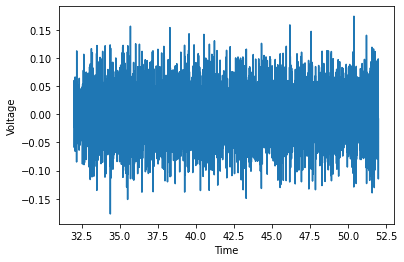

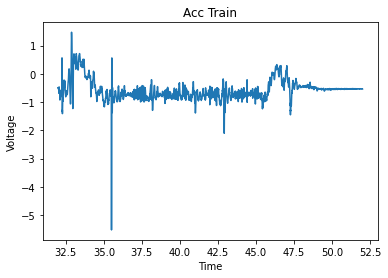

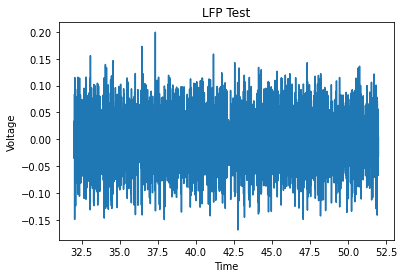

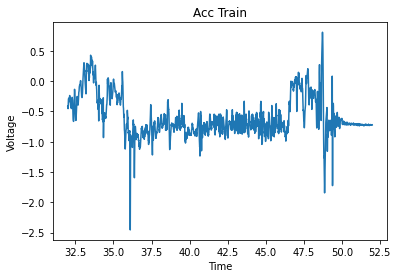

In [5]:
# use one channel for testing
channels = 2
start = 8000  #23000
N = 5000 #2000
fs = 250

d_train = acc_train[0][0][start:start+N]  # x-axis
d_test = acc_train[1][0][start:start+N]  # x-axis

# reformat LFP data
recording_cnt = 4
x_train = []
x_test = np.zeros((4, N))
for j in range(recording_cnt) :
    x_train_t = np.zeros((4, N))
    for i in range(channels) :
        x_train_t[i, :] = lfp_train[j, i][start:(start + N)]
        if (j == 0) :
            x_test[i, :] = lfp_train[5, i][start:(start + N)]
    x_train.append(x_train_t)
    
plt.plot(np.arange(start, start + N) / fs, x_train[0][0, :])
# plt.plot(x_train[1, :])
# plt.plot(x_train[2, :])
# plt.plot(x_train[3, :])
# plt.title("LFP Train")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(start, start + N) / fs, d_train)
plt.title("Acc Train")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(start, start + N) / fs, x_test[0, :])
# plt.plot(x_test[1, :])
# plt.plot(x_test[2, :])
# plt.plot(x_test[3, :])
plt.title("LFP Test")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

plt.plot(np.arange(start, start + N) / fs, d_test)
plt.title("Acc Train")
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.show()

In [6]:
# ### DELETE LATER ###

# # simulate gaussian input noise
# mean = 0
# var = 1
# L = 6002
# y = np.random.normal(mean, var, L)

# # simulate linear channel component
# h = np.array([-0.8, 0.7])
# t = np.convolve(h, y)[0:L]

# # simulate memoryless non-linear channel component
# q = t + 0.25*(t**2) + 0.11*(t**3)

# # add gaussian noise to produce filter input
# P = np.sum(q**2) / L
# SNR = 10**(15/10)
# xn = q + np.sqrt(P/SNR) * np.random.normal(0, 1, L)
# z = np.convolve([0.8, -0.3], y)[0:L]

# x1 = xn[2:2002]
# x2 = z[2:2002]
# x_train = [np.vstack((x1, x2))]
# d_train = y[0:2000]

# x_test = np.vstack((xn[5002:6002], z[5002:6002]))
# d_test = y[5000:6000]

# ####################

## Model training
***

In [7]:
# klms model parameters
verbose = True
kernel_size = [0.1, 1, 10]
embedding_size = [5, 20, 40] 
step_size = [0.2]
threshold = [0.11]
criterion = ['MSE', 'MCC']
entropy_kernel_size = [1, 10]

# perform hyperparameter tuning on model
mse, best_model, y = train_klms(x_train, d_train,
                                x_test, d_test,
                                kernel_size,
                                entropy_kernel_size,
                                embedding_size,
                                step_size,
                                criterion,
                                threshold,
                                all_channels=False,
                                verbose=verbose)

# extract optimal parameters
best_kernel_size = best_model.get_kernel_size()
best_entropy_kernel_size = best_model.get_entropy_kernel_size()
best_embedding_size = best_model.get_embedding_size() 
best_step_size = best_model.get_step_size()
best_criterion = best_model.get_criterion()
best_growth = best_model.get_growth()
best_y = best_model.get_training_output()
J = best_model.get_mse()
#z = best_model.transform(w)

Training Model 1 w/	sigma=0.1
			H sigma=None
			k=5
			eta=0.2
			eps=0.11
			crit=MSE
Model 1 execution time: 3.0753536224365234 seconds
Model 1 Error = 0.1107686602751032 

Training Model 2 w/	sigma=0.1
			H sigma=1
			k=5
			eta=0.2
			eps=0.11
			crit=MCC
			entropy sigma=1
Model 2 execution time: 4.8817174434661865 seconds
Model 2 Error = 0.11130158598626284 

Training Model 3 w/	sigma=0.1
			H sigma=10
			k=5
			eta=0.2
			eps=0.11
			crit=MCC
			entropy sigma=10
Model 3 execution time: 3.655397415161133 seconds
Model 3 Error = 0.11051913059661712 

Training Model 4 w/	sigma=0.1
			H sigma=None
			k=20
			eta=0.2
			eps=0.11
			crit=MSE
Model 4 execution time: 83.4779405593872 seconds
Model 4 Error = 0.11588754423907037 

Training Model 5 w/	sigma=0.1
			H sigma=1
			k=20
			eta=0.2
			eps=0.11
			crit=MCC
			entropy sigma=1
Model 5 execution time: 105.71280884742737 seconds
Model 5 Error = 0.11289277275003477 

Training Model 6 w/	sigma=0.1
			H sigma=10
			k=20
			eta=0.2
			e

-----------------------------
Optimal Parameters
-----------------------------
Kernel Size:		 0.1
Entropy Kernel Size:	 10
Embedding Size:		 5
Step Size:		 0.2
Criterion:		 MCC
-----------------------------


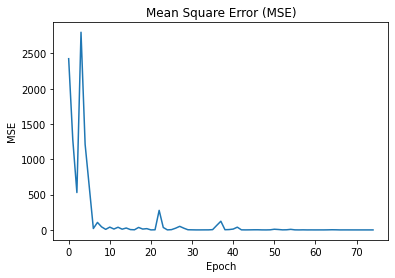

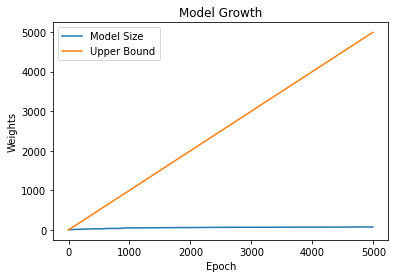

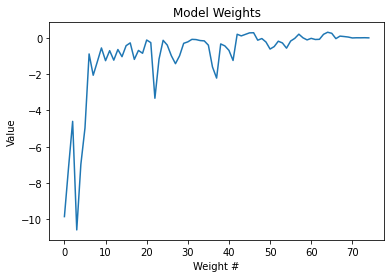

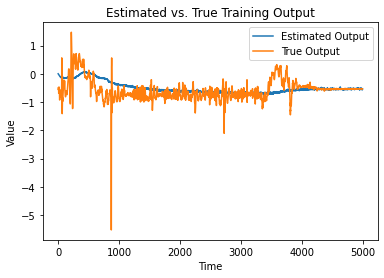

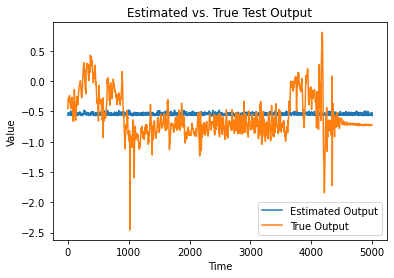

In [8]:
# display results
print("-----------------------------")
print("Optimal Parameters")
print("-----------------------------")
print("Kernel Size:\t\t", best_kernel_size)
print("Entropy Kernel Size:\t", best_entropy_kernel_size)
print("Embedding Size:\t\t", best_embedding_size)
print("Step Size:\t\t", best_step_size)
print("Criterion:\t\t", best_criterion)
print("-----------------------------")

plt.plot(J)
plt.title("Mean Square Error (MSE)")
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

plt.plot(best_growth, label='Model Size')
plt.plot(np.arange(len(best_growth)), label='Upper Bound')
plt.title("Model Growth")
plt.xlabel('Epoch')
plt.ylabel('Weights')
plt.legend()
plt.show()

plt.plot(best_model.get_weights())
plt.title("Model Weights")
plt.xlabel('Weight #')
plt.ylabel('Value')
plt.show()

plt.plot(best_y, label='Estimated Output')
plt.plot(d_train[(best_embedding_size - 1):], label='True Output') # (1000 + best_embedding_size - 1)
plt.title("Estimated vs. True Training Output")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

plt.plot(y, label='Estimated Output')
plt.plot(d_test[(best_embedding_size - 1):], label='True Output')
plt.title("Estimated vs. True Test Output")
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# plt.plot(z, label='Estimated Output')
# plt.plot(w, label='True Output')
# plt.title("Predicted Output")
# plt.xlabel('Time')
# plt.ylabel('Value')
# plt.legend()
# plt.show()

## Save model
***

In [9]:
# save model parameters as ___ file